In [1]:
import torch
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import pandas as pd
import histogram_ext

class ErasplitGBDT(BaseEstimator, RegressorMixin):
    class TreeNode:
        def __init__(self, idx, is_leaf=False, leaf_value=None,
                     feature=None, bin=None, left=None, right=None, samples=0):
            self.idx = idx
            self.is_leaf = is_leaf
            self.leaf_value = leaf_value
            self.feature = feature
            self.bin = bin
            self.left = left
            self.right = right
            self.samples = samples

    def __init__(self, num_bins=10, max_depth=3, learning_rate=0.1, n_estimators=100):
        self.num_bins = num_bins
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.forest = None
        self.bin_edges = None
        self.base_prediction = None
        self.unique_eras = None
        self.device = "cuda"
        self.gradients = None
        self.root_node_indices = None
        self.bin_indices = None
        self.Y_gpu = None
        self.num_features = None
        self.num_samples = None
        self.out_feature = torch.zeros(1, device=self.device, dtype=torch.int32)
        self.out_bin = torch.zeros(1, device=self.device, dtype=torch.int32)
        self.gradient_histogram = None
        self.hessian_histogram = None
        self.max_nodes_per_tree = (2 ** (self.max_depth + 1)) - 1
        self.total_max_nodes = self.n_estimators * self.max_nodes_per_tree
        self.tree_offsets = [i * self.max_nodes_per_tree for i in range(self.n_estimators)]

    def fit(self, X, y, era_id):
        self.bin_indices, _, self.bin_edges, self.unique_eras, self.Y_gpu = self.preprocess_gpu_data(X, y, era_id)
        self.gradient_histogram = torch.zeros((self.num_features, self.num_bins), device=self.device, dtype=torch.float32)
        self.hessian_histogram = torch.zeros((self.num_features, self.num_bins), device=self.device, dtype=torch.float32)
        self.gradients = torch.zeros_like(self.Y_gpu)
        self.root_node_indices = torch.arange(self.num_samples, device=self.device)
        self.base_prediction = self.Y_gpu.mean().item()
        self.gradients += self.base_prediction
        self.tree_nodes = [None] * self.total_max_nodes
        self.next_node_idx = 0
        self.forest = self.grow_forest()
        return self

    def predict(self, X):
        X_tensor = torch.from_numpy(X).float().to(self.device)
        preds = self.predict_forest_batch(X_tensor)
        return preds.cpu().numpy()

    def compute_quantile_bins(self, X, num_bins):
        quantiles = torch.linspace(0, 1, num_bins + 1)[1:-1]
        bin_edges = torch.quantile(X, quantiles, dim=0)
        return bin_edges.T

    def preprocess_gpu_data(self, X_np, Y_np, era_id_np):
        self.num_samples, self.num_features = X_np.shape
        X = torch.from_numpy(X_np).type(torch.float32)
        Y_gpu = torch.from_numpy(Y_np).type(torch.float32).to(self.device)
        era_id_gpu = torch.from_numpy(era_id_np).type(torch.int32).to(self.device)
        bin_edges = self.compute_quantile_bins(X, self.num_bins).type(torch.float32).contiguous()
        bin_indices = torch.empty((self.num_samples, self.num_features), dtype=torch.int8)
        for f in range(self.num_features):
            bin_indices[:, f] = torch.bucketize(X[:, f], bin_edges[f], right=False).type(torch.int8)
        return bin_indices.to(self.device).contiguous(), era_id_gpu, bin_edges.to(self.device), torch.unique(era_id_gpu), Y_gpu

    def compute_histograms(self, bin_indices_sub, gradients):
        self.gradient_histogram.zero_()
        self.hessian_histogram.zero_()
        histogram_ext.compute_histogram(
            bin_indices_sub,
            gradients,
            self.gradient_histogram,
            self.hessian_histogram,
            self.num_bins
        )

    def find_best_split(self):
        histogram_ext.compute_split(
            self.gradient_histogram.contiguous(),
            self.hessian_histogram.contiguous(),
            self.num_features, self.num_bins,
            0.0, 1.0, 1e-6,
            self.out_feature,
            self.out_bin
        )
        return int(self.out_feature[0]), int(self.out_bin[0])

    def grow_tree_flat_prealloc(self, node_indices, depth):
        idx = self.next_node_idx
        self.next_node_idx += 1
        if depth == self.max_depth or node_indices.numel() == 0:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value
            self.tree_nodes[idx] = ErasplitGBDT.TreeNode(idx, is_leaf=True, leaf_value=leaf_value, samples=node_indices.numel())
            return idx
        self.compute_histograms(self.bin_indices[node_indices].contiguous(), self.residual[node_indices].contiguous())
        best_feature, best_bin = self.find_best_split()
        if best_feature == -1:
            leaf_value = (self.Y_gpu[node_indices] - self.gradients[node_indices]).mean()
            self.gradients[node_indices] += self.learning_rate * leaf_value
            self.tree_nodes[idx] = ErasplitGBDT.TreeNode(idx, is_leaf=True, leaf_value=leaf_value, samples=node_indices.numel())
            return idx
        split_mask = self.bin_indices[node_indices, best_feature] <= best_bin
        left_indices = node_indices[split_mask]
        right_indices = node_indices[~split_mask]

        left_idx = self.grow_tree_flat_prealloc(left_indices, depth + 1)
        right_idx = self.grow_tree_flat_prealloc(right_indices, depth + 1)
        self.tree_nodes[idx] = ErasplitGBDT.TreeNode(idx, feature=best_feature, bin=best_bin, left=left_idx, right=right_idx, samples=node_indices.numel())
        return idx

    def grow_forest(self):
        for i in range(self.n_estimators):
            offset = self.tree_offsets[i]
            self.next_node_idx = offset
            self.residual = self.Y_gpu - self.gradients
            self.grow_tree_flat_prealloc(self.root_node_indices, depth=0)
        return self.tree_nodes

    def predict_tree_flat(self, X_tensor, tree_offset):
        N = X_tensor.shape[0]
        preds = torch.empty(N, device=X_tensor.device)
    
        # Start each sample at root of the current tree
        active_nodes = torch.full((N,), tree_offset, dtype=torch.int32, device=X_tensor.device)
        mask = torch.ones(N, dtype=torch.bool, device=X_tensor.device)
    
        while mask.any():
            indices = torch.where(mask)[0]
            for i in indices:
                node_idx = active_nodes[i].item()
                node = self.tree_nodes[node_idx]
    
                if node is None:
                    preds[i] = 0.0  # fallback if tree is malformed
                    mask[i] = False
                    continue
    
                if node.is_leaf:
                    preds[i] = node.leaf_value
                    mask[i] = False
                else:
                    feature_val = X_tensor[i, node.feature]
                    bin_index = torch.bucketize(feature_val, self.bin_edges[node.feature], right=False)
                    if bin_index <= node.bin:
                        active_nodes[i] = node.left
                    else:
                        active_nodes[i] = node.right
    
        return preds
    
    def predict_forest_batch(self, X_tensor):
        N = X_tensor.shape[0]
        preds = torch.full((N,), self.base_prediction, device=X_tensor.device, dtype=torch.float32)
    
        for tree_idx in range(self.n_estimators):
            offset = self.tree_offsets[tree_idx]
            preds += self.learning_rate * self.predict_tree_flat(X_tensor, offset)
    
        return preds


In [2]:
'''
Datasets:

1) Test 2D Dataset with visualization
2) Test High Dimensional Data Set
3) Numerai Data

'''


#1


# # Generate a simple 2D dataset
num_samples = 1000  # Keep it small for clarity

# Generate X in a fun spiral-ish pattern plus some noise
r = np.linspace(0.5, 2.5, num_samples)
theta = np.linspace(0, 4 * np.pi, num_samples)
X1 = r * np.cos(theta) + np.random.normal(0, 0.2, num_samples)
X2 = r * np.sin(theta) + np.random.normal(0, 0.2, num_samples)
X_np = np.stack([X1, X2], axis=1)

# Create a more interesting non-linear target
Y_np = (X_np[:, 0]**2 - X_np[:, 1]**2) + 0.5 * X_np[:, 0]
eras = np.zeros(num_samples)


#2

# def generate_spiral_dataset(num_samples=1_000_000, num_features=10, noise_std=0.2, seed=42):
#     np.random.seed(seed)

#     # Spiral base in 2D
#     r = np.linspace(0.5, 2.5, num_samples)
#     theta = np.linspace(0, 4 * np.pi, num_samples)
#     X1 = r * np.cos(theta) + np.random.normal(0, noise_std, num_samples)
#     X2 = r * np.sin(theta) + np.random.normal(0, noise_std, num_samples)
    
#     # Initial 2D spiral features
#     X = [X1, X2]
    
#     # Create additional synthetic features (some linear, some non-linear)
#     for i in range(2, num_features):
#         if i % 2 == 0:
#             X_i = np.sin(X1) * np.cos(X2) + np.random.normal(0, noise_std, num_samples)
#         else:
#             X_i = X1 * X2 + np.random.normal(0, noise_std, num_samples)
#         X.append(X_i)
    
#     X_np = np.stack(X, axis=1)

#     # Non-linear target function based on first few features
#     Y_np = (X1**2 - X2**2) + 0.5 * X1 + 0.3 * X_np[:, 2] - 0.2 * X_np[:, 3]

#     # Dummy eras
#     eras = np.zeros(num_samples, dtype=int)

#     return X_np, Y_np, eras

# X_np, Y_np, eras = generate_spiral_dataset(num_samples=1_000_000, num_features=10)

#3)

DATA_VERSION = "v5.0"
train = pd.read_parquet(f"../SignalMiner/{DATA_VERSION}/train.parquet")

s = 1_000_000 # num_samples
n = 100 # num_features

feature_set = [ f for f in list(train) if 'feat' in f ][:n]
targets = [ t for t in list(train) if 'target' in t ]


X_np = train[feature_set].values[:s]
Y_np = train[targets[0]].values[:s]
eras = np.zeros(len(Y_np))
f"{len(feature_set) * len(X_np):,}"

'100,000,000'

In [3]:
max_depth = 5
num_bins = 5
n_estimators = 200
learning_rate = 0.01
era_model = ErasplitGBDT(
    max_depth = max_depth,
    num_bins = num_bins,
    n_estimators = n_estimators,
    learning_rate = learning_rate
)

In [4]:
import cProfile
import pstats

# Profile the function and save the results
profiler = cProfile.Profile()
profiler.enable()

# Run the function you want to profile
era_model.fit( X_np, Y_np, eras)

profiler.disable()

# Print profiling stats sorted by cumulative time
stats = pstats.Stats(profiler)
stats.strip_dirs().sort_stats("cumulative").print_stats(100)  # Show top 20 functions


         113622 function calls (101221 primitive calls) in 24.690 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   24.688   12.344 interactiveshell.py:3541(run_code)
        2    0.000    0.000   24.688   12.344 {built-in method builtins.exec}
        1    0.000    0.000   24.688   24.688 3384218672.py:1(<module>)
        1    0.036    0.036   24.688   24.688 641705989.py:45(fit)
        1    0.005    0.005   21.633   21.633 641705989.py:125(grow_forest)
12600/200    2.511    0.000   21.628    0.108 641705989.py:101(grow_tree_flat_prealloc)
     6200   18.703    0.003   18.749    0.003 641705989.py:90(find_best_split)
        1    0.887    0.887    3.018    3.018 641705989.py:68(preprocess_gpu_data)
        1    0.000    0.000    1.047    1.047 641705989.py:63(compute_quantile_bins)
        1    1.046    1.046    1.046    1.046 {built-in method torch.quantile}
      100    0.595    0.006    0.

In [26]:
preds = era_model.predict(X_np[:10])
np.corrcoef([preds, Y_np[:10]])

array([[1.        , 0.38851994],
       [0.38851994, 1.        ]])

In [27]:
import lightgbm as lgb
model = lgb.LGBMRegressor(
    max_depth = max_depth, 
    n_estimators=n_estimators, 
    verbose=-1, 
    max_bins=num_bins, 
    learning_rate=learning_rate, 
    num_leaves=32
)

In [28]:

import cProfile
import pstats

# Profile the function and save the results
profiler = cProfile.Profile()
profiler.enable()

# Run the function you want to profile
model.fit(X_np, Y_np)

profiler.disable()

# Print profiling stats sorted by cumulative time
stats = pstats.Stats(profiler)
stats.strip_dirs().sort_stats("cumulative").print_stats(20)  # Show top 20 functions


         5706 function calls (5312 primitive calls) in 80.576 seconds

   Ordered by: cumulative time
   List reduced from 239 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   80.576   40.288 interactiveshell.py:3541(run_code)
        2    0.000    0.000   80.576   40.288 {built-in method builtins.exec}
        1    0.000    0.000   80.576   80.576 sklearn.py:1075(fit)
        1    0.000    0.000   80.576   80.576 sklearn.py:771(fit)
        1    0.005    0.005   80.574   80.574 engine.py:43(train)
      200   78.519    0.393   78.521    0.393 basic.py:3831(update)
        1    0.361    0.361    2.040    2.040 basic.py:3366(__init__)
        1    0.000    0.000    1.679    1.679 basic.py:2403(construct)
        1    0.001    0.001    1.679    1.679 basic.py:2001(_lazy_init)
        1    1.539    1.539    1.654    1.654 basic.py:2201(__init_from_np2d)
        2    0.059    0.029    0.059    0.029 {method

In [12]:
preds = model.predict(X_np[:1000])
np.corrcoef([preds, Y_np[:1000]])

array([[1.       , 0.7881282],
       [0.7881282, 1.       ]])

In [13]:

# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     # Run the slow function
#     forest = grow_forest(num_trees, root_node_indices, bin_indices, Y_gpu, gradients, num_bins, max_depth, lr)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))



In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid size and range
grid_size = 15
x1_range = np.linspace(-3, 3, grid_size)
x2_range = np.linspace(-3, 3, grid_size)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
X_grid_np = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])  # Flatten for batch prediction


In [15]:
Z_grid = era_model.predict(X_grid_np)
Z_grid.shape

(225,)

In [16]:
Z_grid.reshape(grid_size,grid_size).shape

(15, 15)

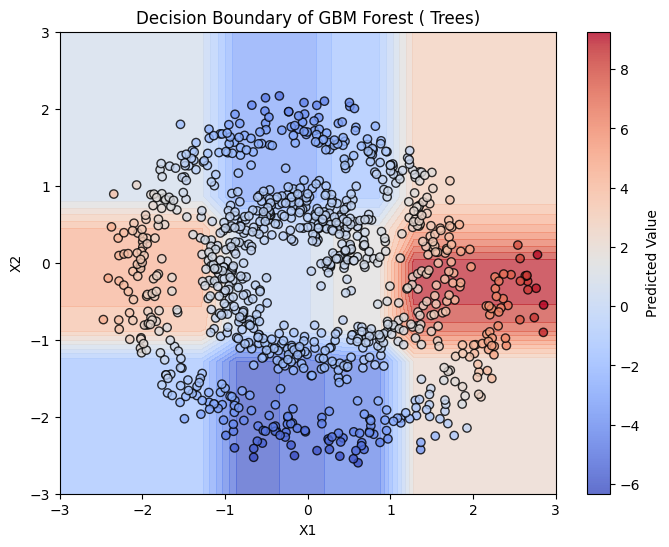

In [17]:
plt.figure(figsize=(8, 6))
plt.contourf(X1_grid, X2_grid, Z_grid.reshape(grid_size,grid_size), levels=20, cmap="coolwarm", alpha=0.7)
plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_np, cmap="coolwarm", edgecolor="k", marker="o", alpha=0.8)
plt.colorbar(label="Predicted Value")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Decision Boundary of GBM Forest ( Trees)")
plt.show()


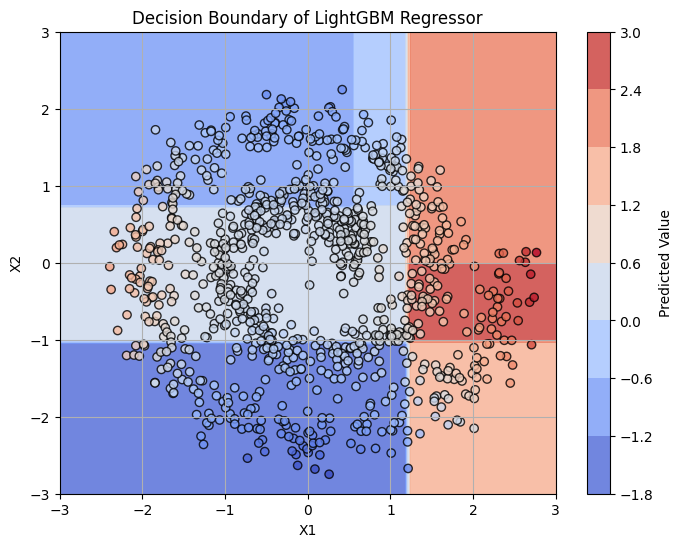

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a grid of values over the same domain as your training data
grid_size = 100
x1 = np.linspace(-3, 3, grid_size)
x2 = np.linspace(-3, 3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.c_[X1.ravel(), X2.ravel()]  # shape: (grid_size**2, 2)

# Use LightGBM model to predict on the grid
Z = model.predict(X_grid)
Z = Z.reshape(X1.shape)

# Plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, Z, cmap='coolwarm', alpha=0.8)
plt.colorbar(contour, label="Predicted Value")
plt.scatter(X_np[:, 0], X_np[:, 1], c=Y_np, edgecolor="k", cmap="coolwarm", alpha=0.8)
plt.title("Decision Boundary of LightGBM Regressor")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)
plt.show()


In [127]:
'''pytorch profiler'''

# import torch.profiler

# with torch.profiler.profile(
#     activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
#     record_shapes=True,
#     profile_memory=True,
#     with_stack=True
# ) as prof:
#     era_model.fit(X_np, Y_np, eras)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))


'pytorch profiler'